In [ ]:
import pandas as pd #reading dataset
import matplotlib as mpl    #plotting, visualization
import matplotlib.pyplot as plt
import tensorflow as tf #building model
from tensorflow.keras.models import Model
import numpy as np  #playing output with model
from sklearn.preprocessing import StandardScaler
import json

import sys
sys.path.append('../../../')   # Add parent directory to Python path
from utils.Plots import *


In [2]:
df = pd.read_csv('../../../data/handlebar/test_data.csv') 
#df.drop('Unnamed: 0', axis=1, inplace=True)
df.shape


(1864, 101)

In [3]:
#scaling data, because neural network works better with scaled data
scaler = StandardScaler()
test_data_scaled = scaler.fit_transform(df.iloc[:, 1:])


In [4]:
# Convert the scaled data back to DataFrames for further processing
test_data_scaled_df = pd.DataFrame(test_data_scaled, columns=df.columns[1:])
test_data_scaled_df['curb_scene'] = df['curb_scene'].values  # Use original DataFrame's curb_scene values
test_data_scaled_df.shape

(1864, 101)

In [5]:
# Filter and slice the data
normal_test_data_scaled = test_data_scaled_df[test_data_scaled_df['curb_scene'] == 0.0].iloc[:, :-1]
abnormal_test_data_scaled = test_data_scaled_df[test_data_scaled_df['curb_scene'] == 1.0].iloc[:, :-1]
normal_test_data_scaled.shape, abnormal_test_data_scaled.shape

((1796, 100), (68, 100))

In [6]:
# Cast to float32
normal_test_data_scaled = normal_test_data_scaled.astype("float32")
abnormal_test_data_scaled = abnormal_test_data_scaled.astype("float32")
normal_test_data_scaled.shape, abnormal_test_data_scaled.shape

((1796, 100), (68, 100))

In [7]:
load_model = tf.keras.models.load_model('../../../models/autoencoder_best.keras')

In [8]:
# Verify the saved data
with open('../../../models/autoencoder_thresholds.json', 'r') as f:
    loaded_thresholds = json.load(f)
print("Saved thresholds:", loaded_thresholds)

Saved thresholds: {'low_threshold': 0.39, 'middle_threshold': 0.81, 'high_threshold': 1.27}


In [9]:
# Get reconstruction errors for test data
reconstructions_normal_test = load_model.predict(normal_test_data_scaled)
reconstructions_abnormal_test = load_model.predict(abnormal_test_data_scaled)
# Calculate MAE losses
test_loss_normal = tf.keras.losses.mae(reconstructions_normal_test, normal_test_data_scaled)
test_loss_abnormal = tf.keras.losses.mae(reconstructions_abnormal_test, abnormal_test_data_scaled)

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [10]:
min_test_loss = min(test_loss_abnormal)
min_test_loss

<tf.Tensor: shape=(), dtype=float32, numpy=0.398254930973053>

In [30]:
# Combine test losses and create true labels
all_test_losses = np.concatenate([test_loss_normal.numpy(), test_loss_abnormal.numpy()])
true_labels = np.concatenate([np.zeros(len(test_loss_normal)), np.ones(len(test_loss_abnormal))])

Results for low_threshold 0.3900:


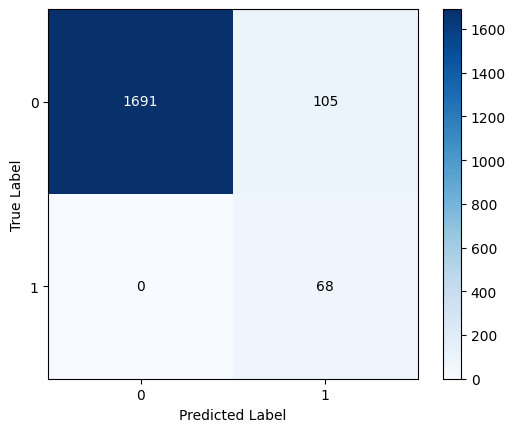

              precision    recall  f1-score   support

  Normal (0)      1.000     0.942     0.970      1796
Abnormal (1)      0.393     1.000     0.564        68

    accuracy                          0.944      1864
   macro avg      0.697     0.971     0.767      1864
weighted avg      0.978     0.944     0.955      1864

Results for middle_threshold 0.8100:


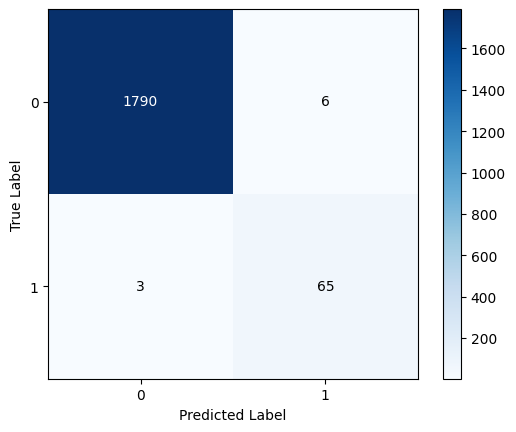

              precision    recall  f1-score   support

  Normal (0)      0.998     0.997     0.997      1796
Abnormal (1)      0.915     0.956     0.935        68

    accuracy                          0.995      1864
   macro avg      0.957     0.976     0.966      1864
weighted avg      0.995     0.995     0.995      1864

Results for high_threshold 1.2700:


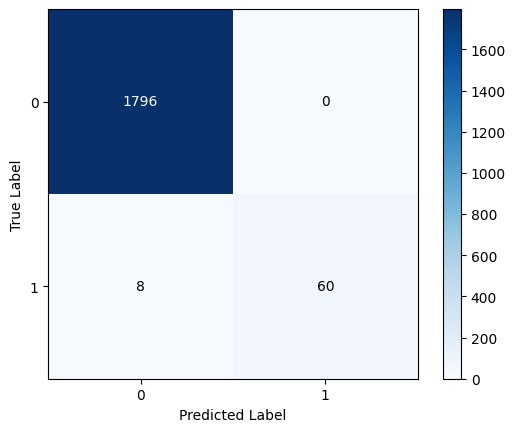

              precision    recall  f1-score   support

  Normal (0)      0.996     1.000     0.998      1796
Abnormal (1)      1.000     0.882     0.938        68

    accuracy                          0.996      1864
   macro avg      0.998     0.941     0.968      1864
weighted avg      0.996     0.996     0.996      1864



In [34]:
# Make predictions using each threshold
for threshold_name, threshold_value in loaded_thresholds.items():
    print(f"Results for {threshold_name} {threshold_value:.4f}:")
    predictions = (all_test_losses > threshold_value).astype(int)
    plot_confusion_matrix(true_labels, predictions)